In [1]:
import glob
import os
import json

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import cPickle as pkl


from pipeline.python.classifications import experiment_classes as util


import scipy.stats as spstats

from pipeline.python.utils import label_figure, natural_keys
from pipeline.python.classifications import bootstrap_fit_tuning_curves as osi
from pipeline.python.classifications import get_dataset_stats as gd

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
   

# Get session info

In [2]:
options = ['-t', 'traces001']

optsE = gd.extract_options(options)


rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type

print aggregate_dir

/n/coxfs01/julianarhee/aggregate-visual-areas


In [3]:
sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)

In [4]:
sdata.head()

,animalid,experiment,fov,session,visual_area,exp_no,animal_no
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,3,4
1,JC084,gratings,FOV1_zoom2p0x,20190522,V1,1,4
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,0,4
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,2,4
4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm,3,4


In [5]:
dsets = sdata[sdata['experiment']=='gratings']

In [6]:
dsets

,animalid,experiment,fov,session,visual_area,exp_no,animal_no
1,JC084,gratings,FOV1_zoom2p0x,20190522,V1,1,4
5,JC084,gratings,FOV1_zoom2p0x,20190525,Lm,1,4
9,JC091,gratings,FOV1_zoom2p0x,20190627,Lm,1,7
13,JC091,gratings,FOV1_zoom2p0x,20190607,Li,1,7
17,JC091,gratings,FOV1_zoom2p0x,20190614,Li,1,7
21,JC091,gratings,FOV1_zoom2p0x,20190606,Li,1,7
26,JC091,gratings,FOV1_zoom2p0x,20190602,Li,1,7
31,JC085,gratings,FOV1_zoom2p0x,20190622,V1,1,5
35,JC090,gratings,FOV1_zoom2p0x,20190605,Li,1,6
39,JC099,gratings,FOV1_zoom2p0x,20190612,Li,1,9


In [40]:
traceid = 'traces001'

response_type = 'dff'
responsive_test = None #'nstds' #'ROC'
responsive_thr = 10 #0.05
n_bootstrap_iters=1000
n_resamples = 20

In [41]:
fit_desc = osi.get_fit_desc(response_type=response_type, responsive_test=responsive_test, responsive_thr=responsive_thr,
                            n_bootstrap_iters=n_bootstrap_iters, n_resamples=n_resamples)
print fit_desc

fit-dff_all-cells_boot-1000-resample-20


In [42]:
aggregate_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas'

In [43]:
destdir = os.path.join(aggregate_dir, 'orientation-tuning', '%s-%s' % (traceid, fit_desc))

In [44]:
aggstats_fpath = glob.glob(os.path.join(destdir, '*.pkl'))[0]
with open(aggstats_fpath, 'rb') as f:
    stats = pkl.load(f)
stats

{'JC078_20190513_FOV1_zoom2p0x': array([ 11,  12,  16,  17,  27,  28,  31,  33,  34,  43,  45,  49,  50,
         52,  65,  66,  70,  73,  77,  79,  80,  84,  88,  91,  94,  95,
         96, 102, 104, 110, 112, 116, 120, 122, 124, 129, 133, 134, 137,
        138, 139, 144, 149, 150, 152, 156, 165, 169, 172, 177, 181, 183,
        188, 204, 206, 207, 214, 215, 225, 226, 228, 229, 233, 234, 237,
        238, 239, 240, 248, 253, 262, 266, 269, 279]),
 'JC080_20190603_FOV1_zoom2p0x': array([  1,   3,  25,  30,  33,  39,  43,  44,  46,  48,  53,  54,  58,
         60,  74,  84,  91, 100, 101, 104, 107, 109, 110, 111, 116, 117,
        120, 121, 122, 127, 129, 131, 135, 136, 143, 144, 151, 152, 160,
        163, 167, 169, 172, 178, 180, 181, 183, 194, 196, 200, 208, 209,
        212, 214, 215, 218, 223, 225, 228, 229, 233, 238, 239, 244, 249,
        251, 267, 268, 270, 271, 272, 273]),
 'JC083_20190511_FOV1_zoom2p0x': array([  1,  11,  23,  26,  27,  30,  32,  33,  34,  37,  40,  42,  44,
 

In [45]:
[(skey, len(vals)) for skey, vals in stats.items()]

[('JC080_20190603_FOV1_zoom2p0x', 72),
 ('JC090_20190605_FOV1_zoom2p0x', 55),
 ('JC091_20190602_FOV1_zoom2p0x', 67),
 ('JC091_20190627_FOV1_zoom2p0x', 47),
 ('JC083_20190517_FOV1_zoom2p0x', 38),
 ('JC099_20190609_FOV1_zoom2p0x', 24),
 ('JC097_20190617_FOV1_zoom2p0x', 66),
 ('JC099_20190617_FOV1_zoom2p0x', 13),
 ('JC097_20190616_FOV1_zoom2p0x', 107),
 ('JC083_20190511_FOV1_zoom2p0x', 58),
 ('JC083_20190512_FOV1_zoom2p0x', 74),
 ('JC084_20190525_FOV1_zoom2p0x', 63),
 ('JC091_20190606_FOV1_zoom2p0x', 42),
 ('JC099_20190612_FOV1_zoom2p0x', 26),
 ('JC085_20190622_FOV1_zoom2p0x', 81),
 ('JC091_20190607_FOV1_zoom2p0x', 67),
 ('JC097_20190613_FOV1_zoom2p0x', 56),
 ('JC084_20190522_FOV1_zoom2p0x', 62),
 ('JC091_20190614_FOV1_zoom2p0x', 71),
 ('JC078_20190513_FOV1_zoom2p0x', 74)]

In [46]:
[(skey, len(vals)) for skey, vals in stats.items()]

[('JC080_20190603_FOV1_zoom2p0x', 72),
 ('JC090_20190605_FOV1_zoom2p0x', 55),
 ('JC091_20190602_FOV1_zoom2p0x', 67),
 ('JC091_20190627_FOV1_zoom2p0x', 47),
 ('JC083_20190517_FOV1_zoom2p0x', 38),
 ('JC099_20190609_FOV1_zoom2p0x', 24),
 ('JC097_20190617_FOV1_zoom2p0x', 66),
 ('JC099_20190617_FOV1_zoom2p0x', 13),
 ('JC097_20190616_FOV1_zoom2p0x', 107),
 ('JC083_20190511_FOV1_zoom2p0x', 58),
 ('JC083_20190512_FOV1_zoom2p0x', 74),
 ('JC084_20190525_FOV1_zoom2p0x', 63),
 ('JC091_20190606_FOV1_zoom2p0x', 42),
 ('JC099_20190612_FOV1_zoom2p0x', 26),
 ('JC085_20190622_FOV1_zoom2p0x', 81),
 ('JC091_20190607_FOV1_zoom2p0x', 67),
 ('JC097_20190613_FOV1_zoom2p0x', 56),
 ('JC084_20190522_FOV1_zoom2p0x', 62),
 ('JC091_20190614_FOV1_zoom2p0x', 71),
 ('JC078_20190513_FOV1_zoom2p0x', 74)]

# Aggregate all tuning data

In [47]:
# animalid = 'JC084'
# session ='20190522'

In [48]:
rootdir = '/n/coxfs01/2p-data'
# fov_type = 'zoom2p0x'


In [49]:
def get_average_tuning_over_iters(fitdf):
    means = {}
    roi = int(fitdf['cell'].unique()[0])
    for param in fitdf.columns:
        if 'theta' in param:
            meanval = np.rad2deg(spstats.circmean(np.deg2rad(fitdf[param].values % 360.)))
        else:
            meanval = fitdf[param].values.mean()
        
        means[param] = meanval
    
    return pd.DataFrame(means, index=[roi])

In [50]:
gdata = []
for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
    
    dpath = glob.glob(os.path.join(rootdir, animalid, session, fov, '*gratings*',
                                  'traces', '%s*' % traceid, 'tuning', fit_desc, '*_evaluation.pkl'))[0]
    with open(dpath, 'rb') as f:
        d = pkl.load(f)
    df = d['fits']
    meandf = pd.concat([get_average_tuning_over_iters(g) for k, g in df.groupby(['cell'])], axis=0)
    ncells = meandf.shape[0]
    meandf['visual_area'] = [visual_area for _ in range(ncells)]
    meandf['animalid'] = [animalid for _ in range(ncells)]
    meandf['session'] = [session for _ in range(ncells)]
    meandf['fov'] = [fov for _ in range(ncells)]
    
    gdata.append(meandf)
        

In [51]:
gdata = pd.concat(gdata, axis=0)
gdata.head()

,ASI,DSI,cell,gof,preferred_theta,r2,r2comb,visual_area,animalid,session,fov
1,0.095787,0.451474,1.0,0.497857,48.699499,0.709365,0.492571,Li,JC090,20190605,FOV1_zoom2p0x
2,0.376397,0.664998,2.0,0.322526,168.067615,0.597926,0.344634,Li,JC090,20190605,FOV1_zoom2p0x
3,0.441975,0.167648,3.0,NaN,53.217076,0.582099,-1.178084,Li,JC090,20190605,FOV1_zoom2p0x
4,0.607189,0.388614,4.0,0.456616,68.054606,0.674024,0.699244,Li,JC090,20190605,FOV1_zoom2p0x
5,0.700616,0.622286,5.0,0.774244,219.414962,0.921272,0.706286,Li,JC090,20190605,FOV1_zoom2p0x


# Visualize

In [52]:
%matplotlib notebook

In [53]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

In [54]:
def compare_tuning_metric(df, metric='ASI', cdf=False, ax=None, area_colors=None, show_legend=True, alpha=1):
    if ax is None:
        fig, ax = pl.subplots(figsize=(6,4))
        fig.patch.set_alpha(1)
    if area_colors is None:
        visual_areas = sorted(df['visual_area'].unique())
        colors = sns.color_palette(palette='cubehelix', n_colors=len(visual_areas))
        area_colors = dict((k, col) for k, col in zip(visual_areas, colors))
       

    for visual_area, tmpd in df.groupby(['visual_area']):
        nrats = len(tmpd['animalid'].unique())
        ncells_total = tmpd.shape[0]
        values = tmpd[metric].values
        weights = np.ones_like(values)/float(len(values))
        ax.hist(values, 
                cumulative=cdf,
                label='%s (n=%i rats, %i cells)' % (visual_area, nrats, ncells_total),
                color=area_colors[visual_area],
                histtype='step', alpha=alpha, lw=3,
                normed=0, weights=weights)
    if show_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
    #sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel(metric)
    if cdf:
        ax.set_ylabel('CDF')
    else:
        ax.set_ylabel('fraction')

In [55]:
aggregate_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas'

In [56]:
fit_desc

'fit-dff_all-cells_boot-1000-resample-20'

# Set output dir for aggregate figures

In [57]:
data_identifier = '|'.join(['gratings', fov_type, traceid, fit_desc])
data_identifier

'gratings|zoom2p0x|traces001|fit-dff_all-cells_boot-1000-resample-20'

In [58]:
gdata.head()

,ASI,DSI,cell,gof,preferred_theta,r2,r2comb,visual_area,animalid,session,fov
1,0.095787,0.451474,1.0,0.497857,48.699499,0.709365,0.492571,Li,JC090,20190605,FOV1_zoom2p0x
2,0.376397,0.664998,2.0,0.322526,168.067615,0.597926,0.344634,Li,JC090,20190605,FOV1_zoom2p0x
3,0.441975,0.167648,3.0,NaN,53.217076,0.582099,-1.178084,Li,JC090,20190605,FOV1_zoom2p0x
4,0.607189,0.388614,4.0,0.456616,68.054606,0.674024,0.699244,Li,JC090,20190605,FOV1_zoom2p0x
5,0.700616,0.622286,5.0,0.774244,219.414962,0.921272,0.706286,Li,JC090,20190605,FOV1_zoom2p0x


In [59]:
destdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/orientation-tuning/traces001-fit-dff_all-cells_boot-1000-resample-20'

<IPython.core.display.Javascript object>


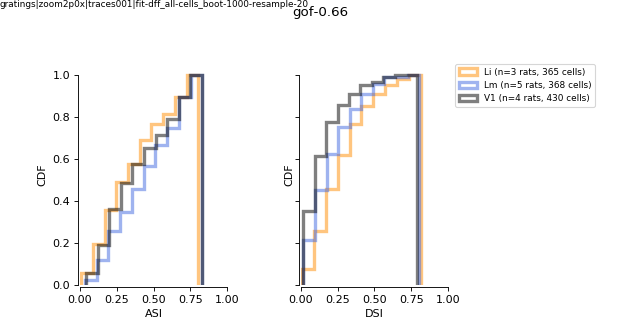

ASI-DSI_gof-0.66_cdf


In [60]:
gof = 0.66
cdf = True
alpha = 0.5
filter_gof = True
if filter_gof:
    roi_str = 'gof-%.2f' % gof
    rdata = gdata[gdata['gof'] >= gof]
else:
    roi_str = 'all-cells'
    rdata = gdata.copy()

fig, axes = pl.subplots(1,2, sharex=True, sharey=True, figsize=(8,4))
fig.patch.set_alpha(1)

ax = axes[0]
compare_tuning_metric(rdata, metric='ASI', cdf=cdf, area_colors=area_colors, ax=ax, show_legend=False, alpha=alpha)
ax = axes[1]
compare_tuning_metric(rdata, metric='DSI', cdf=cdf, area_colors=area_colors, ax=ax, alpha=alpha)

pl.subplots_adjust(wspace=0.5, right=0.7, top=0.8)
fig.suptitle(roi_str)
for ax in axes:
    ax.set_xlim([0, 1])
    sns.despine(ax=ax, trim=True, offset=2)
    
    
label_figure(fig, data_identifier)
figname = 'ASI-DSI_%s_%s' % (roi_str, 'cdf' if cdf else 'hist')
pl.savefig(os.path.join(destdir, '%s.png' % figname))
print figname

In [56]:
meandf.shape

(119, 7)

In [57]:
meandf[meandf['gof'] >= gof].shape

(44, 7)